In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [44]:
data = pd.read_excel(
    r"DATA\export pruebas normalizacion nitrato 26112025.xls", sheet_name="n_damian.wke"
)

In [45]:
data.columns

Index(['Row', 'Identifier 1', 'Identifier 2', 'Amount', 'Comment', 'Peak Nr',
       'Ampl  28', 'Ampl  29', 'Area 28', 'Area 29', 'R 15N/14N', 'd 15N/14N'],
      dtype='object')

In [46]:
names_map = {
    "Identifier 1": "sample_name",
    "Peak Nr": "peak_number",
    "d 15N/14N": "d15N_raw",
    "Amount": "amount",
    "Ampl 28": "ampl_28",
    "Row": "row",
    "Ampl 29": "ampl_29",
    "Ampl 30": "ampl_30",
    "R 15N/14N": "r15N/14N",
}

In [47]:
# columnas no usadas
data = data.drop(columns=["Comment", "Identifier 2"])

# renombrar columnas
data = data.rename(columns=names_map)
data.head()

,row,sample_name,amount,peak_number,Ampl 28,Ampl 29,Area 28,Area 29,r15N/14N,d15N_raw
0,8,blanco sin capsula,0.000,1,4745,3421,89.006,0.642,0.003678,0.000
1,9,blanco sin capsula,0.000,1,4805,3465,89.960,0.649,0.003678,0.000
2,10,nitrato ES3,0.558,1,4838,3489,90.546,0.653,0.003678,0.000
3,10,nitrato ES3,0.558,2,5055,3592,71.990,0.511,0.003622,-15.346
4,11,nitrato ES3,0.588,1,4874,3514,91.145,0.657,0.003678,0.000


In [48]:
# Row 26, problemas en la inyeccion de referencia
data = data[data.row != 26]

# separo en ref y samples
ref = data[data.peak_number == 1]
df = data[data.peak_number == 2]

In [49]:
df.head()

,row,sample_name,amount,peak_number,Ampl 28,Ampl 29,Area 28,Area 29,r15N/14N,d15N_raw
3,10,nitrato ES3,0.558,2,5055,3592,71.990,0.511,0.003622,-15.346
5,11,nitrato ES3,0.588,2,5445,3867,78.306,0.556,0.003622,-15.414
7,12,nitrato ES3,0.592,2,5314,3774,77.983,0.554,0.003622,-15.287
9,13,nitrato ES3,0.559,2,4891,3474,71.222,0.506,0.003622,-15.412
11,14,nitrato ES6,0.487,2,5684,4128,83.973,0.610,0.003702,6.575


OBS: Nitrato ES6 parec inhomogeneo, vimos el mismo comportamiento anteriormente.


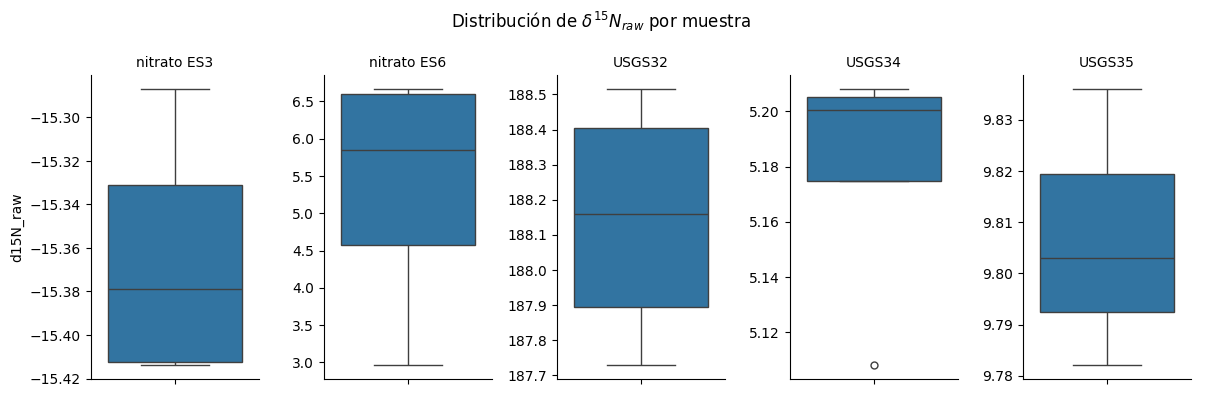

In [50]:
g = sns.catplot(
    df,
    col="sample_name",
    y="d15N_raw",
    kind="box",
    sharey=False,
    col_wrap=5,
    height=4,
    aspect=0.6,
    whis=1.5,  # aumentar el rango de los bigotes
)
g.set_titles("{col_name}")
g.figure.suptitle("Distribución de $\delta^{15}N_{raw}$ por muestra")

plt.tight_layout()

In [51]:
summary = df.groupby("sample_name")["d15N_raw"].agg(["mean", "std", "count"])
summary

,mean,std,count
sample_name,,,
USGS32,188.14050,0.364268,4
USGS34,5.17925,0.047717,4
USGS35,9.80700,0.027221,3
nitrato ES3,-15.36475,0.060704,4
nitrato ES6,5.32700,1.732011,4


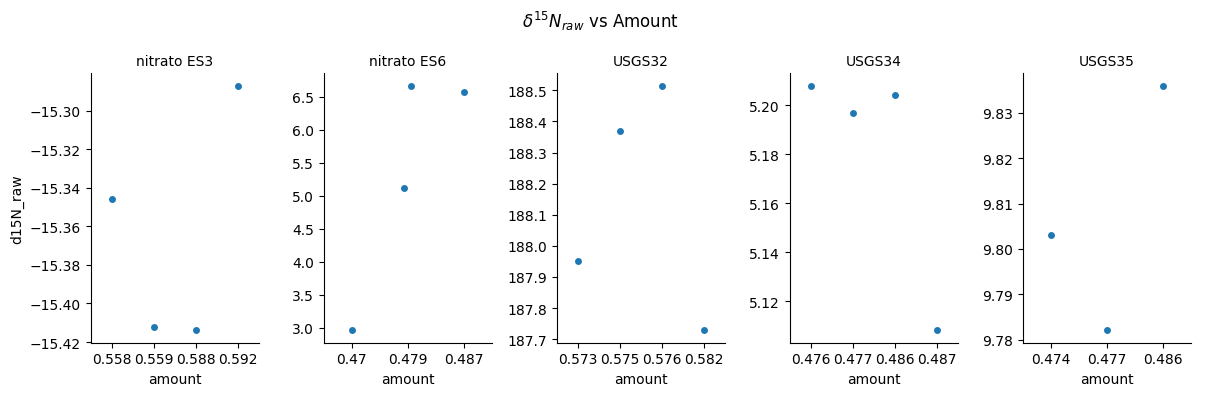

In [52]:
g = sns.catplot(
    data=df,
    x="amount",
    y="d15N_raw",
    col="sample_name",
    sharey=False,
    sharex=False,
    col_wrap=5,
    height=4,
    aspect=0.6,
)

g.set_titles("{col_name}")
g.figure.suptitle("$\delta^{15}N_{raw}$ vs Amount")
plt.tight_layout()

In [53]:
# elijo los extremos para normalizar y el valor central para verificar exactitud
standards_dict = {"USGS32": 180.0, "USGS34": -1.8, "USGS35": 2.7}

df["True_Value"] = df["sample_name"].map(standards_dict)

# Create a subset for Calibration (High/Low) and Validation (Middle)
cal_standards = df[df["sample_name"].isin(["USGS32", "USGS34"])]
val_standard = df[df["sample_name"] == "USGS35"]
samples = df[~df["sample_name"].isin(["USGS32", "USGS34", "USGS35"])]

C:\Users\Damm\AppData\Local\Temp\ipykernel_2028\2083797982.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['True_Value'] = df['sample_name'].map(standards_dict)


In [54]:
from scipy.stats import linregress

# Group by identifier to get the mean of replicates for the regression
# (Using means prevents one standard with more replicates from biasing the line)
cal_means = cal_standards.groupby("sample_name")[["d15N_raw", "True_Value"]].mean()
slope, intercept, r_value, p_value, std_err = linregress(
    x=cal_means["d15N_raw"], y=cal_means["True_Value"]
)

print(f"Normalization Equation: y = {slope:.4f}x + {intercept:.4f}")
print(f"R-squared: {r_value**2:.4f}")

Normalization Equation: y = 0.9937x + -6.9464
R-squared: 1.0000


In [55]:
df["d15N_Corrected"] = df["d15N_raw"] * slope + intercept

C:\Users\Damm\AppData\Local\Temp\ipykernel_2028\3538717600.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['d15N_Corrected'] = df['d15N_raw'] * slope + intercept


In [56]:
# Filter for USGS35 in the full dataframe
check_std = df[df["sample_name"] == "USGS35"]

# Calculate Metrics
observed_mean = check_std["d15N_Corrected"].mean()
true_val = standards_dict["USGS35"]
bias = observed_mean - true_val
rmse = np.sqrt(((check_std["d15N_Corrected"] - true_val) ** 2).mean())

print(f"--- USGS35 VALIDATION ---")
print(f"Certified Value: {true_val:.3f}")
print(f"Observed Value:  {observed_mean:.3f}")
print(f"Bias (Trueness): {bias:.3f} per mil")
print(f"RMSE:            {rmse:.3f}")

--- USGS35 VALIDATION ---
Certified Value: 2.700
Observed Value:  2.798
Bias (Trueness): 0.098 per mil
RMSE:            0.101


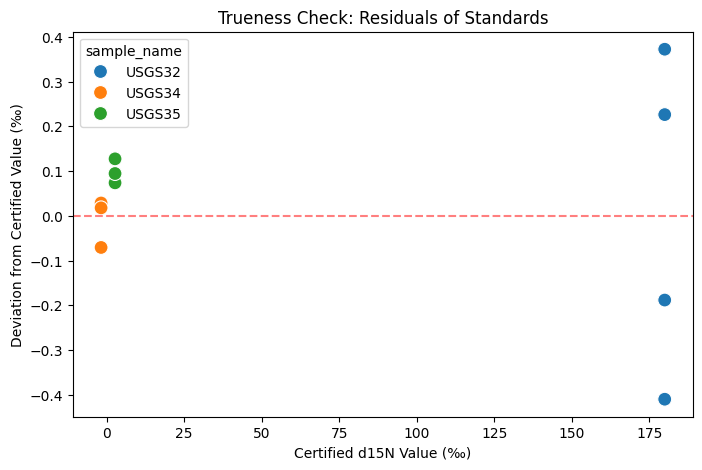

In [57]:
# Calculate residuals for standards only
df_stds = df[df["sample_name"].isin(["USGS32", "USGS34", "USGS35"])].copy()
df_stds["Residual"] = df_stds["d15N_Corrected"] - df_stds["True_Value"]

plt.figure(figsize=(8, 5))
sns.scatterplot(data=df_stds, x="True_Value", y="Residual", hue="sample_name", s=100)
plt.axhline(0, color="red", linestyle="--", alpha=0.5)
plt.title("Trueness Check: Residuals of Standards")
plt.ylabel("Deviation from Certified Value (‰)")
plt.xlabel("Certified d15N Value (‰)")
plt.show()

In [59]:
ref_data = {
    "USGS32": {"val": 180.0, "unc": 1.2},
    "USGS34": {"val": -1.8, "unc": 0.2},
    # USGS35 is treated as a sample/check in this workflow
}

# Mean and SEM
stats = df.groupby("sample_name")["d15N_raw"].agg(["mean", "sem", "count"])

# Extract values for the Standards (The Anchors)
rm1_name, rm2_name = "USGS32", "USGS34"

rm1_raw_mean = stats.loc[rm1_name, "mean"]
rm1_raw_sem = stats.loc[rm1_name, "sem"]
rm1_cert_val = ref_data[rm1_name]["val"]
rm1_cert_unc = ref_data[rm1_name]["unc"]

rm2_raw_mean = stats.loc[rm2_name, "mean"]
rm2_raw_sem = stats.loc[rm2_name, "sem"]
rm2_cert_val = ref_data[rm2_name]["val"]
rm2_cert_unc = ref_data[rm2_name]["unc"]


# --- 3. THE KRAGTEN ALGORITHM ---
def calculate_kragten(row):
    """
    Calculates corrected value and combined uncertainty using Kragten method.
    """
    # 1. Inputs for this specific sample
    sample_raw = row["mean"]
    sample_sem = row[
        "sem"
    ]  # If sem is NaN (n=1), handle it (defaults to 0 or detection limit)
    if pd.isna(sample_sem):
        sample_sem = 0

    # 2. Define the Model Function (The FIRMS Equation)
    def model(x_samp, x1, x2, y1, y2):
        slope = (y1 - y2) / (x1 - x2)
        return y1 + (x_samp - x1) * slope

    # 3. Calculate Nominal Result (The Base Case)
    nominal_val = model(
        sample_raw, rm1_raw_mean, rm2_raw_mean, rm1_cert_val, rm2_cert_val
    )

    # 4. Perturbations (The Kragten Loop)
    # We calculate the result when EACH parameter is increased by its uncertainty

    # Param 1: Sample Raw Uncertainty
    y_u_samp = model(
        sample_raw + sample_sem, rm1_raw_mean, rm2_raw_mean, rm1_cert_val, rm2_cert_val
    )
    d_samp = y_u_samp - nominal_val

    # Param 2: RM1 Raw Uncertainty
    y_u_rm1_raw = model(
        sample_raw, rm1_raw_mean + rm1_raw_sem, rm2_raw_mean, rm1_cert_val, rm2_cert_val
    )
    d_rm1_raw = y_u_rm1_raw - nominal_val

    # Param 3: RM2 Raw Uncertainty
    y_u_rm2_raw = model(
        sample_raw, rm1_raw_mean, rm2_raw_mean + rm2_raw_sem, rm1_cert_val, rm2_cert_val
    )
    d_rm2_raw = y_u_rm2_raw - nominal_val

    # Param 4: RM1 Certified Uncertainty
    y_u_rm1_cert = model(
        sample_raw,
        rm1_raw_mean,
        rm2_raw_mean,
        rm1_cert_val + rm1_cert_unc,
        rm2_cert_val,
    )
    d_rm1_cert = y_u_rm1_cert - nominal_val

    # Param 5: RM2 Certified Uncertainty
    y_u_rm2_cert = model(
        sample_raw,
        rm1_raw_mean,
        rm2_raw_mean,
        rm1_cert_val,
        rm2_cert_val + rm2_cert_unc,
    )
    d_rm2_cert = y_u_rm2_cert - nominal_val

    # 5. Combine (Sum of Squares)
    u_combined = np.sqrt(
        d_samp**2 + d_rm1_raw**2 + d_rm2_raw**2 + d_rm1_cert**2 + d_rm2_cert**2
    )

    return pd.Series(
        [nominal_val, u_combined], index=["Corrected_Mean", "Uncertainty_1s"]
    )


# --- 4. APPLY TO DATA ---
# Apply the function to the aggregated stats DataFrame
results = stats.apply(calculate_kragten, axis=1)

# Display
print(results.round(3))

             Corrected_Mean  Uncertainty_1s
sample_name                                
USGS32              180.000           1.227
USGS34               -1.800           0.203
USGS35                2.798           0.199
nitrato ES3         -22.214           0.264
nitrato ES6          -1.653           0.884
